In [67]:
import pandas as pd
import glob
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, SubsetRandomSampler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
import torch.optim as optim
from plotnine import *
from sklearn.base import BaseEstimator, TransformerMixin

In [68]:
# Import Data
folder_path = "data/crypto"
all_files = glob.glob(os.path.join(folder_path, "*.csv"))

dfs = []
for file in all_files:
    df = pd.read_csv(file, usecols=["Symbol", "Date", "Close"])
    dfs.append(df)

# Combine all files
securities = pd.concat(dfs, ignore_index=True)

# Pivot to wide format
sec_wide = securities.pivot(index="Date", columns="Symbol", values="Close")

# Remove the "Symbol" column name
sec_wide.columns.name = None

# Remove unwanted columns safely
remove_cols = ['WBTC', 'USDT', 'USDC']
sec_wide = sec_wide.drop(columns=remove_cols)

# Parse Date as datetime
sec_wide.index = pd.to_datetime(sec_wide.index)

# Remove rows with any NaN values
sec_wide = sec_wide.dropna()

# Optional: reset index so Date becomes a column
sec_wide = sec_wide.reset_index()

print(sec_wide.head())

                 Date       AAVE       ADA      ATOM        BNB           BTC  \
0 2020-10-05 23:59:59  53.219243  0.097544  5.382198  28.659104  10793.339428   
1 2020-10-06 23:59:59  42.401599  0.092808  4.732915  27.714528  10604.405889   
2 2020-10-07 23:59:59  40.083976  0.093800  4.886457  27.704836  10668.968955   
3 2020-10-08 23:59:59  43.764463  0.096152  5.045788  27.705311  10915.685731   
4 2020-10-09 23:59:59  46.817744  0.101925  5.157042  28.445031  11064.457592   

        CRO      DOGE       DOT       EOS  ...       LINK        LTC  \
0  0.150009  0.002612  4.172700  2.529068  ...   9.623703  46.363226   
1  0.147198  0.002611  3.756162  2.693054  ...   8.779272  45.985530   
2  0.147583  0.002595  3.858798  2.646043  ...   8.957850  46.660479   
3  0.150626  0.002596  4.102642  2.609671  ...   9.508818  47.218381   
4  0.152428  0.002653  4.262468  2.645295  ...  10.346902  47.832955   

      MIOTA       SOL       TRX       UNI       XEM       XLM         XMR  \
0  

In [69]:
class MeanScaler(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        X = np.asarray(X)
        self.mean_ = np.mean(X, axis=0, keepdims=True)
        return self

    def transform(self, X):
        X = np.asarray(X)
        return X / self.mean_

    def inverse_transform(self, X_scaled):
        X_scaled = np.asarray(X_scaled)
        return X_scaled * self.mean_

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using: {device}")

Using: cuda


Find Weights Using Gradeint Descent

In [71]:
# Make target and features
base = 'BTC'
X = sec_wide.drop(columns=['Date', base])
y = sec_wide[base].values.reshape(-1, 1)

# Scale data
scalar_X = MeanScaler()
scalar_y = MeanScaler()

X_scaled = scalar_X.fit_transform(X.values)
y_scaled = scalar_y.fit_transform(y)

# Convert to torch tensors
X = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(y_scaled, dtype=torch.float32)

# Train-test split
split_percent = 0.9
split_idx = int(split_percent * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Create DataLoaders
batch_size = 8
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [72]:
# Model
class LinearRegressionModel(nn.Module):
    def __init__ (self, input_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1, bias=False) # just a linear combination of inputs

    def forward(self, x):
        return self.linear(x) # no activation function, just linear
    
model = LinearRegressionModel(X.shape[1]).to(device)

In [73]:
# Training Setup
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [74]:
# Training Loop
epochs = 1000
# Define fractions per epoch (repeat if epochs > 9)
fractions = [1.0]*250 + [0.5]*250 + [0.25]*500
if epochs > len(fractions):
    # Extend the last fraction for remaining epochs
    fractions += [fractions[-1]]*(epochs - len(fractions))

# Put model on device
model.to(device)

for epoch in range(epochs):
    # Determine fraction for this epoch
    frac = fractions[epoch]
    n_samples = int(len(train_dataset) * frac)
    
    # Randomly select indices
    indices = np.random.choice(len(train_dataset), n_samples, replace=False)
    sampler = SubsetRandomSampler(indices)
    
    # Create a DataLoader for this epoch
    train_loader_epoch = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)
    
    # Training loop for this epoch
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader_epoch:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
    
    train_loss /= n_samples  # average over sampled dataset
    
    # Evaluate on test set every 10 epochs
    if (epoch+1) % 50 == 0 or (epoch == 0):
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                test_outputs = model(X_batch)
                loss = criterion(test_outputs, y_batch)
                test_loss += loss.item() * X_batch.size(0)
        test_loss /= len(test_loader.dataset)
        
        print(f'Epoch [{epoch+1}/{epochs}], fraction={frac}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


Epoch [1/1000], fraction=1.0, Train Loss: 0.0568, Test Loss: 0.0052
Epoch [50/1000], fraction=1.0, Train Loss: 0.0089, Test Loss: 0.0294
Epoch [100/1000], fraction=1.0, Train Loss: 0.0064, Test Loss: 0.0359
Epoch [150/1000], fraction=1.0, Train Loss: 0.0056, Test Loss: 0.0248
Epoch [200/1000], fraction=1.0, Train Loss: 0.0050, Test Loss: 0.0108
Epoch [250/1000], fraction=1.0, Train Loss: 0.0049, Test Loss: 0.0191
Epoch [300/1000], fraction=0.5, Train Loss: 0.0041, Test Loss: 0.0107
Epoch [350/1000], fraction=0.5, Train Loss: 0.0047, Test Loss: 0.0128
Epoch [400/1000], fraction=0.5, Train Loss: 0.0048, Test Loss: 0.0159
Epoch [450/1000], fraction=0.5, Train Loss: 0.0051, Test Loss: 0.0083
Epoch [500/1000], fraction=0.5, Train Loss: 0.0053, Test Loss: 0.0123
Epoch [550/1000], fraction=0.25, Train Loss: 0.0037, Test Loss: 0.0160
Epoch [600/1000], fraction=0.25, Train Loss: 0.0032, Test Loss: 0.0165
Epoch [650/1000], fraction=0.25, Train Loss: 0.0046, Test Loss: 0.0127
Epoch [700/1000], fr

In [75]:
# Extract Weights
raw_weights = model.cpu().linear.weight.detach().numpy().flatten()

# Rescale weights
weights = raw_weights * scalar_y.mean_ / scalar_X.mean_
print("Weights unscaled: ", weights)

Weights unscaled:  [[-2.27371045e+00  8.39880709e+03 -4.02423240e+02 -2.45115036e+01
   4.28767989e+04 -3.79937929e+04 -8.46440532e+01 -2.95985334e+03
   3.28470772e+00  1.57248339e+02  1.53570565e+02  3.58899917e+03
  -8.76821989e+01  9.63808114e+04  2.54919791e+02  2.18134412e+03
   1.57373352e+04  3.32655817e+01 -4.55190538e+03]]


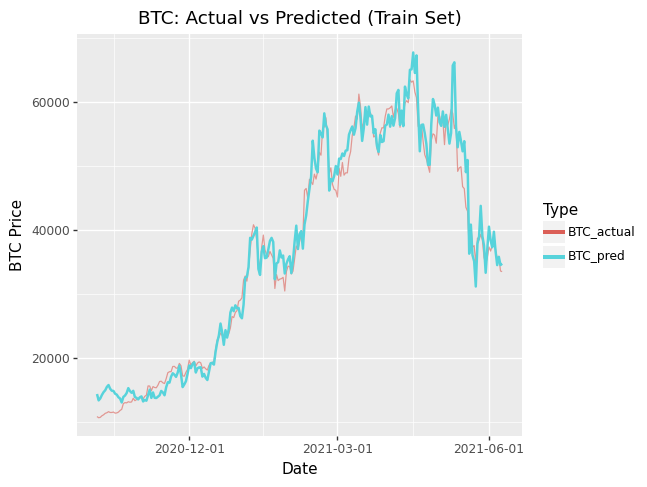

In [ ]:
# Select only feature columns (exclude Date and target/base)
X_cols = sec_wide.drop(columns=['Date', base])

# Convert to NumPy for elementwise multiplication
weighted_sum = (X_cols.values * weights).sum(axis=1)

# Put into DataFrame
portfolio = pd.DataFrame({
    'Date': sec_wide['Date'],
    'Weighted_Sum': weighted_sum
})

# Plot
df_plot_train = pd.DataFrame({
    'Date': sec_wide['Date'][:split_idx].reset_index(drop=True),
    'BTC_actual': sec_wide[base].iloc[:split_idx].to_numpy().flatten(),
    'BTC_pred': portfolio['Weighted_Sum'].iloc[:split_idx].to_numpy().flatten()
})

# Melt for plotting
df_melt_train = df_plot_train.melt(
    id_vars='Date',
    value_vars=['BTC_actual', 'BTC_pred'],
    var_name='Type',
    value_name='BTC'
)

# Plot with legend
p_train = (
    ggplot(df_melt_train, aes(x='Date', y='BTC', color='Type')) +
    geom_line(df_melt_train[df_melt_train['Type'] == 'BTC_actual'], alpha=0.6) +
    geom_line(df_melt_train[df_melt_train['Type'] == 'BTC_pred'], size=1) +
    ggtitle('BTC: Actual vs Predicted (Train Set)') +
    xlab('Date') +
    ylab('BTC Price')
)

p_train.draw()



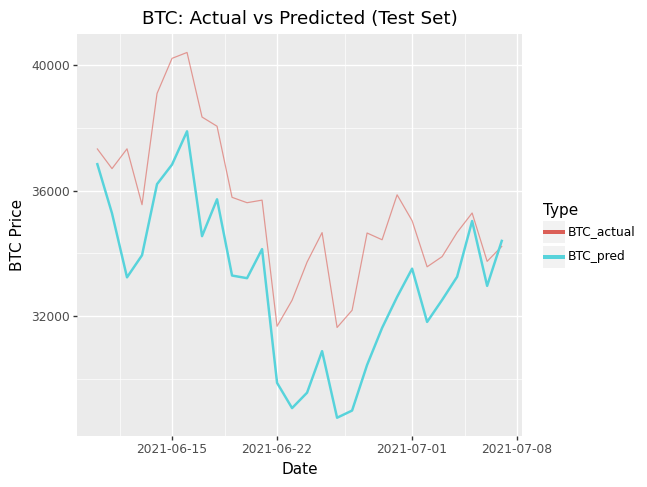

In [77]:
# Compute weighted portfolio again (if not already done)
X_cols = sec_wide.drop(columns=['Date', base])
weighted_sum = (X_cols.values * weights).sum(axis=1)

portfolio = pd.DataFrame({
    'Date': sec_wide['Date'],
    'Weighted_Sum': weighted_sum
})

# Plot test set
df_plot_test = pd.DataFrame({
    'Date': sec_wide['Date'].iloc[split_idx:].reset_index(drop=True),
    'BTC_actual': sec_wide[base].iloc[split_idx:].to_numpy().flatten(),
    'BTC_pred': portfolio['Weighted_Sum'].iloc[split_idx:].to_numpy().flatten()
})

# Melt for plotting
df_melt_test = df_plot_test.melt(
    id_vars='Date',
    value_vars=['BTC_actual', 'BTC_pred'],
    var_name='Type',
    value_name='BTC'
)

# Plot with legend
p_test = (
    ggplot(df_melt_test, aes(x='Date', y='BTC', color='Type')) +
    geom_line(df_melt_test[df_melt_test['Type'] == 'BTC_actual'], alpha=0.6) +
    geom_line(df_melt_test[df_melt_test['Type'] == 'BTC_pred'], size=1) +
    ggtitle('BTC: Actual vs Predicted (Test Set)') +
    xlab('Date') +
    ylab('BTC Price')
)

p_test.draw()


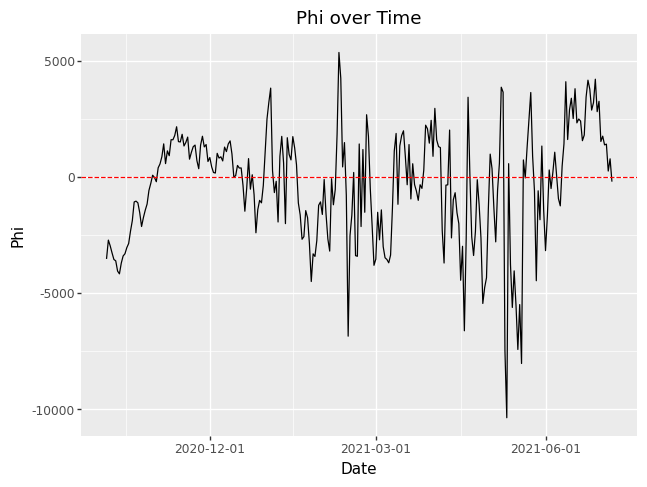

In [78]:
# Find PHI

phi = sec_wide[base].subtract(weighted_sum, axis=0)

phi_df = pd.DataFrame({
    'Date': sec_wide['Date'],
    'phi': phi
})

p_phi = (
    ggplot(phi_df, aes(x='Date', y='phi')) +
    geom_line() +
    ggtitle('Phi over Time') +
    xlab('Date') +
    ylab('Phi') +
    geom_hline(yintercept=0, linetype='dashed', color='red')
)
p_phi.draw()

In [79]:
# Find AR(1) parameters
import statsmodels.api as sm

frac = 1/4
print(round(len(phi)*frac))

phi_tail = phi[round(len(train_dataset)*(1-frac)):split_idx] # use phi from end of training data

model_ar = sm.tsa.ARIMA(phi_tail, order=(1,0,0))
result = model_ar.fit()
print(result.summary())

gamma = result.params['ar.L1']
mu = result.params['const']
sigma2 = result.params['sigma2']

69
                               SARIMAX Results                                
Dep. Variable:                    BTC   No. Observations:                   62
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -577.655
Date:                Fri, 24 Oct 2025   AIC                           1161.310
Time:                        17:16:23   BIC                           1167.692
Sample:                             0   HQIC                          1163.816
                                 - 62                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1682.5390    641.242     -2.624      0.009   -2939.351    -425.727
ar.L1          0.4266      0.087      4.914      0.000       0.256       0.597
sigma2      7.317e+06   1.31e+06      5.573      

Using LSTM to find Weights

In [80]:
import torch
from torch.utils.data import DataLoader, TensorDataset

window_size = 30

# Make target and features
base = 'BTC'
X = sec_wide.drop(columns=['Date', base])
y = sec_wide[base].values.reshape(-1, 1)

# Scale data
scalar_X = MeanScaler()
scalar_y = MeanScaler()

X_scaled = scalar_X.fit_transform(X.values)
y_scaled = scalar_y.fit_transform(y)

# Convert to torch tensors
X = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(y_scaled, dtype=torch.float32)

# Create sliding windows
X_seq, y_seq = [], []
for i in range(len(X) - window_size + 1):
    X_seq.append(X[i:i + window_size])     # 30-day window
    y_seq.append(y[i + window_size - 1])   # target = last day in window


X_seq = torch.stack(X_seq)  # shape: (num_windows, window_size, num_features)
y_seq = torch.stack(y_seq)  # shape: (num_windows, 1)

# Train-test split
split_percent = 0.9
split_idx = int(split_percent * len(X_seq))
X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]

# Create DataLoaders
batch_size = 8
train_dataset_lstm = TensorDataset(X_train, y_train)
test_dataset_lstm = TensorDataset(X_test, y_test)
train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=batch_size, shuffle=True)
test_loader_lstm = DataLoader(test_dataset_lstm, batch_size=batch_size, shuffle=False)


In [81]:
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, feature_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_size=feature_dim, hidden_size=128, num_layers=4, batch_first=True)
        self.fc = nn.Linear(128, feature_dim, bias=False)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        weights = self.fc(lstm_out[:, -1, :])  # use last time step
        base_price = torch.matmul(x[:, -1, :], weights.t())  # weighted sum of last day features
        return base_price
# NOTE: could use base in LSTM but not in dot product for better weights
    
model = LSTMModel(X_seq.shape[2]).to(device)

In [82]:
# Training Setup
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [83]:
# Train LSTM
epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader_lstm:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * X_batch.size(0)
    
    train_loss /= len(train_loader_lstm.dataset)
    
    # Evaluate on test set every 10 epochs
    if (epoch+1) % 10 == 0 or (epoch == 0):
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader_lstm:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                test_outputs = model(X_batch)
                loss = criterion(test_outputs, y_batch)
                test_loss += loss.item() * X_batch.size(0)
        test_loss /= len(test_loader_lstm.dataset)
        
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

C:\Users\Parker Smith\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([8, 1])) that is different to the input size (torch.Size([8, 8])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
C:\Users\Parker Smith\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch [1/100], Train Loss: 0.1280, Test Loss: 0.0612
Epoch [10/100], Train Loss: 0.0164, Test Loss: 0.0445
Epoch [20/100], Train Loss: 0.0069, Test Loss: 0.0053
Epoch [30/100], Train Loss: 0.0040, Test Loss: 0.0098
Epoch [40/100], Train Loss: 0.0123, Test Loss: 0.0381
Epoch [50/100], Train Loss: 0.0041, Test Loss: 0.0067
Epoch [60/100], Train Loss: 0.0041, Test Loss: 0.0161
Epoch [70/100], Train Loss: 0.0035, Test Loss: 0.0184
Epoch [80/100], Train Loss: 0.0035, Test Loss: 0.0060
Epoch [90/100], Train Loss: 0.0049, Test Loss: 0.0194
Epoch [100/100], Train Loss: 0.0036, Test Loss: 0.0036


In [84]:
# LSTM Weights Only
class LSTMModelWeightsOnly(nn.Module):
    def __init__(self, feature_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_size=feature_dim, hidden_size=128, num_layers=4, batch_first=True)
        self.fc = nn.Linear(128, feature_dim, bias=False)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        weights = self.fc(lstm_out[:, -1, :])
        return weights
model_weights = LSTMModelWeightsOnly(X_seq.shape[2])
model_weights.load_state_dict(model.state_dict(), strict=False)

<All keys matched successfully>

In [85]:
# Get the last 30-day window (already scaled and tensorized)
X_last = X_seq[-1].unsqueeze(0)  # shape: (1, 30, num_features)

# Put model in evaluation mode
model_weights.eval()

# Get the weights for the most recent window
with torch.no_grad():
    raw_weights = model_weights(X_last)  # shape: (1, num_features)

# Unscale weights
latest_weights = raw_weights * scalar_y.mean_ / scalar_X.mean_
print("Weights unscaled: ", latest_weights)

Weights unscaled:  tensor([[ 1.2881e+01,  2.5217e+03, -1.4268e+02, -1.9093e+01,  1.0644e+05,
         -2.4696e+04, -7.8300e+01, -2.4324e+03,  4.8294e+00, -6.9674e+01,
          1.1715e+02,  4.2972e+02, -8.9167e+01,  7.1440e+04,  6.0925e+01,
          1.9114e+03,  1.8594e+04,  4.3715e+01, -5.4950e+03]],
       dtype=torch.float64)


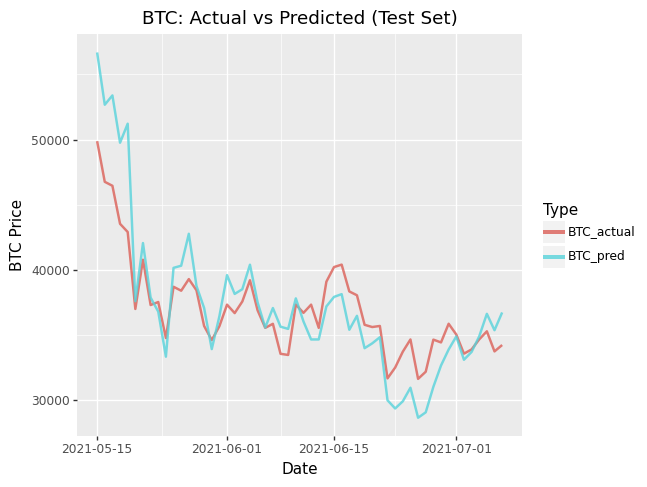

In [101]:
# Compute weighted portfolio using LSTM
X_cols = sec_wide.drop(columns=['Date', base]).reset_index(drop=True)

phi_values = []
pseudo_prices = []
pseudo_dates = []

model_weights.eval()
with torch.no_grad():
    for i in range(window_size, X_cols.shape[0]):
        # Use past window of 30 days
        window = X_cols.iloc[i - window_size:i].values
        price_seq = torch.tensor(window, dtype=torch.float32).unsqueeze(0)  # (1, 30, features)

        # Predict dynamic weights
        raw_weight_vec = model_weights(price_seq)
        weight_vec = (raw_weight_vec * scalar_y.mean_ / scalar_X.mean_).to(torch.float32).squeeze()

        # Apply weights to current day prices
        price_vec = torch.tensor(X_cols.iloc[i].values, dtype=torch.float32)
        pseudo_price = torch.matmul(price_vec, weight_vec).item()
        base_price = sec_wide[base].iloc[i]

        pseudo_prices.append(pseudo_price)
        phi_values.append(base_price - pseudo_price)
        pseudo_dates.append(sec_wide['Date'].iloc[i])

# Build full pseudo DataFrame
pseudo_df = pd.DataFrame({'Date': pd.to_datetime(pseudo_dates), 'Pseudo': pseudo_prices})
phi_df = pd.DataFrame({'Date': pd.to_datetime(pseudo_dates), 'Phi': phi_values})

# --- Strictly align to test set ---
test_dates = sec_wide['Date'].iloc[split_idx:].reset_index(drop=True)
base_actual = sec_wide[base].iloc[split_idx:].reset_index(drop=True)

# Filter pseudo_df to only test dates
pseudo_test = pseudo_df[pseudo_df['Date'].isin(test_dates)].reset_index(drop=True)

# Build plot DataFrame
min_len = min(len(test_dates), len(base_actual), len(pseudo_test))
df_plot_test = pd.DataFrame({
    'Date': test_dates[:min_len],
    f'{base}_actual': base_actual[:min_len],
    f'{base}_pred': pseudo_test['Pseudo'][:min_len]
})

# Melt for ggplot
df_melt_test = df_plot_test.melt(
    id_vars='Date',
    value_vars=[f'{base}_actual', f'{base}_pred'],
    var_name='Type',
    value_name=base
)

# Plot
p_test = (
    ggplot(df_melt_test, aes(x='Date', y=base, color='Type')) +
    geom_line(alpha=0.8, size=1) +
    ggtitle(f'{base}: Actual vs Predicted (Test Set)') +
    xlab('Date') +
    ylab(f'{base} Price')
)

p_test.draw()



In [87]:
# TODO: Find PHI, AR(1) params, backtest